In [7]:
import torch
from torch import nn

cut_zero_grad = 1
back_activation = 0

class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            # 在全局变量中保存输入图片的梯度，该梯度由第一层卷积层
            # 反向传播得到，因此该函数需绑定第一个 Conv2d Layer
            self.image_reconstruction = grad_in[0]

        def forward_hook_fn(module, input, output):
            # 在全局变量中保存 ReLU 层的前向传播输出
            # 用于将来做 guided backpropagation
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            # ReLU 层反向传播时，用其正向传播的输出作为 guide
            # 反向传播和正向传播相反，先从后面传起
            grad = self.activation_maps.pop() 
            # ReLU 正向传播的输出要么大于0，要么等于0，
            # 大于 0 的部分，梯度为1，
            # 等于0的部分，梯度还是 0
            if cut_zero_grad:
                grad[grad > 0] = 1
            
                # grad_out[0] 表示 feature 的梯度，只保留大于 0 的部分
                positive_grad_out = torch.clamp(grad_out[0], min=0.0)
                # 创建新的输入端梯度
                new_grad_in = positive_grad_out * grad

                # ReLU 不含 parameter，输入端梯度是一个只有一个元素的 tuple
                return (new_grad_in,)
            else:
                if back_activation:
                    return (grad,)
                return (grad_out[0],)

        # 获取 module，这里只针对 alexnet，如果是别的，则需修改
        modules = list(self.model.features.named_children())

        # 遍历所有 module，对 ReLU 注册 forward hook 和 backward hook
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # 对第1层卷积层注册 hook
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class):
        # 获取输出，之前注册的 forward hook 开始起作用
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
        
        # 生成目标类 one-hot 向量，作为反向传播的起点
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        # 反向传播，之前注册的 backward hook 开始起作用 
        model_output.backward(grad_target_map)
        # 得到 target class 对输入图片的梯度，转换成图片格式
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result.numpy()

def normalize(I):
    # 归一化梯度map，先归一化到 mean=0 std=1
    norm = (I-I.mean())/I.std()
    # 把 std 重置为 0.1，让梯度map中的数值尽可能接近 0
    norm = norm * 0.1
    # 均值加 0.5，保证大部分的梯度值为正
    norm = norm + 0.5
    # 把 0，1 以外的梯度值分别设置为 0 和 1
    norm = norm.clip(0, 1)
    return norm



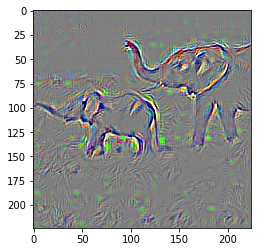

END


In [8]:

if __name__=='__main__':
    from torchvision import models, transforms
    from PIL import Image
    import matplotlib.pyplot as plt

    image_path = './elephant.jpeg'
    I = Image.open(image_path).convert('RGB')
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    size = 224

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(I).unsqueeze(0).requires_grad_()

    model = models.alexnet(pretrained=True)

    guided_bp = Guided_backprop(model)
    result = guided_bp.visualize(tensor, None)

    result = normalize(result)
    plt.imshow(result)
    if cut_zero_grad:
        plt.savefig("cut_zero_grad.png")
    else:
        if back_activation:
            plt.savefig("back_activation.png")
        else:
            plt.savefig("full_grad.png")
    plt.show()


    print('END')
